# Suresonix Statistical Analysis
Dr Daniel Duke

Department of Mechanical & Aerospace Engineering

Monash University

29/10/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, datetime, os, natsort, sys
import matplotlib as mpl
%matplotlib widget

In [2]:
path="/Users/dduke/Library/CloudStorage/GoogleDrive-daniel.duke@monash.edu/My Drive/ExperimentData/2024_Suresonix/Shared with Suresonix/raw_data_ASCII/"
tsvFiles = glob.glob(path+"*.txt")

## Batch processing of ASCII data

In [3]:
# Process PCL TSV data, with time axis starting at 
# -time_offset and dt=30 for averaging window.
def process_timeseries(filename,time_offset=60,dt=30,plot_raw=False,a_min=0):
    
    # Read data
    with open(filename,'r') as F:
        for n in range(26): F.readline()
        header=F.readline().strip().split('\t')
    
    M=np.genfromtxt(filename,skip_header=28,dtype="str")

    # Process time stamp, convert from absolute to seconds since start of sampling
    timestamps = []
    for i in range(M.shape[0]):
        ts=datetime.datetime.strptime(' '.join(M[i,:3]),'%d/%m/%y %H:%M %S')
        if i==0: 
            ts0=ts
            timestamps.append(0.)
        else: timestamps.append((ts-ts0).total_seconds())
    timestamps=np.array(timestamps)
    
    timestamps -= time_offset #s offset

    # Size distribution data
    size_bins = np.array([ float(x) for x in header[10:10+60] ])
    size_dist = M[:,10:10+60].astype(float)
    
    # Signal intensity
    M[M[:,7]=='---',7:9]=np.nan # masking ---
    a = 1 - 0.01*M[:,7].astype(float) # laser absorption
    Cv = M[:,8].astype(float) # Malvern reported Cv [ppm]

    if plot_raw:
        # Raw data plot
        fig=plt.figure()
    
        xx,yy=np.meshgrid(size_bins,timestamps)
        p=plt.pcolormesh(yy,xx,np.nan_to_num(size_dist),shading='nearest',\
                         vmax=(0.5*np.nanmax(size_dist)),cmap='viridis')
        plt.xlabel('Time after Start of Delivery [s]')
        plt.ylabel(r'Size [$\mu$m]')
        plt.title(os.path.basename(os.path.splitext(filename)[0]));
        plt.gca().set_yscale('log')
        plt.ylim(1.6,)
        
        ax2=plt.gca().twinx()
        plt.ylabel('Absorption/PPM')
        ax2.plot(timestamps,a*100,lw=2,c='r',label='Laser absorption')
        ax2.plot(timestamps,Cv,lw=2,c='lime',label='Cv [approx. ppm]')
        cb=plt.colorbar(p,pad=0.12,label='Size distribution')
        plt.legend();
        plt.savefig(os.path.splitext(filename)[0]+"_NoAveraging.png")
    
    # Conditional boxcar average
    t=np.arange(timestamps.min(),timestamps.max(),dt)
    size_dist_avg = [size_dist[0,:]]
    a_avg = [0]; a_std=[0];
    Cv_avg = [0]; Cv_std=[0];
    for i in range(len(t)-1):
        # indices of points to average: within time window & absorption sufficiently high
        i = np.where((timestamps<t[i+1])&(timestamps>=t[i])&(a>a_min))[0]
        if np.any(~np.isnan(size_dist[i,:])):
            size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
            a_avg.append( np.nanmean(a[i]) )
            Cv_avg.append( np.nanmean(Cv[i]) )
            a_std.append( np.nanstd(a[i]) )
            Cv_std.append( np.nanstd(Cv[i]) )
        else:
            size_dist_avg.append( np.zeros_like(size_bins) )
            a_avg.append(np.nan)
            Cv_avg.append(np.nan)
            a_std.append(np.nan)
            Cv_std.append(np.nan)
        
    size_dist_avg = np.array(size_dist_avg)
    a_avg = np.array(a_avg)
    a_std = np.array(a_std)
    
    return t, size_bins, size_dist_avg, np.array(Cv_avg), np.array(Cv_std)

In [4]:
def calc_size_stat(size_bins, size_dist):
    d32_vals = []
    gsd_vals = []
    for i in range(size_dist.shape[0]): # each time step

        # Get d32
        if np.any(~np.isnan(size_dist_avg[i,:])) and np.any(size_dist_avg[i,:]>0):
            d32_ = np.sum( size_dist_avg[i,:] * size_bins**3 )
            d32_ /= np.sum( size_dist_avg[i,:] * size_bins**2 )
            d32_vals.append(d32_)
        else:
            d32_vals.append(np.nan)

        # Get GSD
        if np.any(~np.isnan(size_dist_avg[i,:])) and np.any(size_dist_avg[i,:]>0):
            n = float(len(size_bins))
            sizes = size_dist_avg[i,:] * size_bins / np.sum(size_dist_avg[i,:])
            sizes = sizes[sizes>0] # don't take the log of zero.
            gsd_ = np.sqrt( np.sum( np.log(sizes/np.nanmean(sizes))**2 ) / n )
            gsd_vals.append(gsd_)
        else:
            gsd_vals.append(np.nan)
        
    return np.array(d32_vals), np.array(gsd_vals)

## Size Stats Table Generation

Compute stats and generate table for report.

In [5]:
print("EXPERIMENT\t\t1:00-2:30\t\t2:30-3:30\t\t3:30-5:00")
print('\t\t'+'\tD32\t   GSD   '*3)
print('-'*100)
for filename in natsort.natsorted(tsvFiles):
    t, size_bins, size_dist_avg, Cv_avg, Cv_std = process_timeseries(filename,time_offset=60)
    d32,gsd = calc_size_stat(size_bins, size_dist_avg)

    case = os.path.splitext(os.path.basename(filename))[0]
    
    sys.stdout.write('%s\t' % case[:20])
    for time_range in [(60,150),(150,210),(210,300)]:
        i = np.where((t>=time_range[0]) & (t<=time_range[1]))[0]
        sys.stdout.write('%4.2f±%.2f  %4.2f±%.2f  ' % (np.mean(d32[i]),np.std(d32[i]),np.mean(gsd[i]),np.std(gsd[i])))
    sys.stdout.write('\n')
    

EXPERIMENT		1:00-2:30		2:30-3:30		3:30-5:00
			D32	   GSD   	D32	   GSD   	D32	   GSD   
----------------------------------------------------------------------------------------------------
test1_n1_entry_fanOn	7.29±1.59  2.53±1.20  9.57±0.16  1.19±0.03  11.05±1.27  1.38±0.25  
test2_n1_center_fanO	7.87±2.32  1.36±0.44  8.91±0.66  0.98±0.13  8.74±0.30  0.95±0.20  
test3_n1_return_fanO	 nan±nan   nan±nan  13.09±0.06  2.42±0.51  13.10±0.10  2.54±0.54  
test4_n1_corner_fan1	6.56±1.93  2.28±1.21  5.47±0.21  2.94±0.33  5.99±0.30  2.25±0.52  
test5_n1_corner_fan6	5.90±0.41  2.58±0.73  6.91±0.27  2.52±0.15  7.83±0.38  1.71±0.54  
test6_n2_entry_fanOn	5.44±0.08  2.46±0.53  5.56±0.06  2.49±0.46  6.21±0.77  2.08±0.61  
test7_n2_center_fanO	5.66±0.05  2.08±0.12  5.77±0.12  1.92±0.29  6.50±0.50  1.75±0.35  
test8_n2_return_fanO	 nan±nan   nan±nan   nan±nan   nan±nan   nan±nan   nan±nan  
test9_n3_return_fanO	 nan±nan   nan±nan  6.92±0.43  2.30±0.22  7.55±0.30  2.94±0.63  
test10_n3_entry_fanO	5.17

## Cv table generation

In [6]:
print("EXPERIMENT\t\t1:00-2:30\t2:30-3:30\t3:30-5:00")
print('\t\t'+'\tCv [PPM]'*3)
print('-'*100)
for filename in natsort.natsorted(tsvFiles):
    t, size_bins, size_dist_avg, Cv_avg, Cv_std = process_timeseries(filename,time_offset=60)
    
    case = os.path.splitext(os.path.basename(filename))[0]
    
    sys.stdout.write('%s\t' % case[:20])
    for time_range in [(60,150),(150,210),(210,300)]:
        i = np.where((t>=time_range[0]) & (t<=time_range[1]))[0]
        sys.stdout.write('%4.3f ± %4.3f\t' % (np.mean(Cv_avg[i]),np.std(Cv_avg[i])+np.mean(Cv_std[i])))
    sys.stdout.write('\n')
    

EXPERIMENT		1:00-2:30	2:30-3:30	3:30-5:00
			Cv [PPM]	Cv [PPM]	Cv [PPM]
----------------------------------------------------------------------------------------------------
test1_n1_entry_fanOn	8.229 ± 0.772	8.756 ± 0.936	10.100 ± 1.125	
test2_n1_center_fanO	2.156 ± 1.247	2.414 ± 0.495	3.514 ± 1.312	
test3_n1_return_fanO	 nan ±  nan	0.496 ± 0.395	1.446 ± 0.709	
test4_n1_corner_fan1	1.749 ± 0.970	1.933 ± 0.403	1.798 ± 0.296	
test5_n1_corner_fan6	2.453 ± 1.037	2.271 ± 0.626	2.892 ± 0.769	
test6_n2_entry_fanOn	2.924 ± 0.186	2.760 ± 0.361	1.895 ± 0.794	
test7_n2_center_fanO	1.007 ± 0.234	1.097 ± 0.319	1.359 ± 0.348	
test8_n2_return_fanO	 nan ±  nan	 nan ±  nan	 nan ±  nan	
test9_n3_return_fanO	 nan ±  nan	0.194 ± 0.210	0.711 ± 0.408	
test10_n3_entry_fanO	2.964 ± 2.262	3.608 ± 1.415	5.971 ± 1.716	
test11_n3_center_fan	1.693 ± 1.210	2.907 ± 0.509	3.676 ± 0.674	
test12_n3_return_fan	5.262 ± 7.296	1.836 ± 0.691	1.145 ± 0.518	
test13_n2_corner_fan	2.572 ± 1.179	2.001 ± 1.130	1.747 ± 0.855	
test

## Size stats bar charts

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_57868/1513167606.py:19: RuntimeWarning: Mean of empty slice
  time_avg_data[os.path.basename(filename)] = np.nanmean(d32[i]) + 1j * np.nanmean(gsd[i])


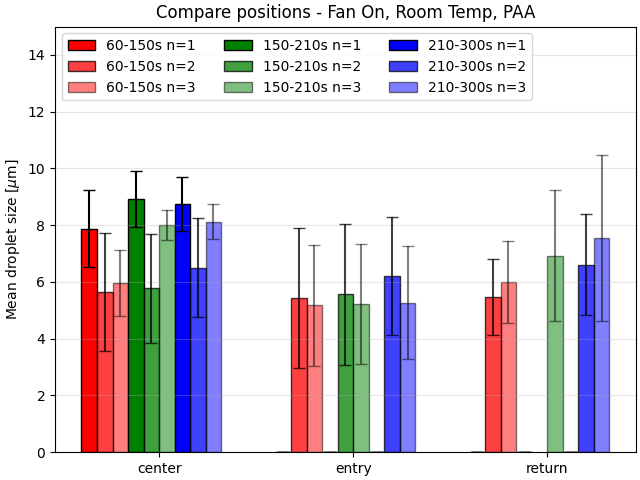

In [94]:
for fL,descriptor in [(glob.glob(path+"test[26789]_*fanOn_roomTemp_acid.txt")+\
                       glob.glob(path+"test1?_*fanOn_roomTemp_acid.txt"), 'Compare positions - Fan On, Room Temp, PAA')]:
        
    data_means={}
    categories = ['center','entry','return']
    
    for time_range in [(60,150),(150,210),(210,300)]:

        #  Get data in time range for all tests.
        time_avg_data={}
        for filename in natsort.natsorted(fL):
            t, size_bins, size_dist_avg, Cv_avg, Cv_std = process_timeseries(filename,time_offset=60)
            d32,gsd = calc_size_stat(size_bins, size_dist_avg)
            i = np.where((t>=time_range[0]) & (t<=time_range[1]))[0]

            #(np.mean(d32[i]),np.std(d32[i]),np.mean(gsd[i]),np.std(gsd[i])))
            # store mean and error as complex number.
            
            time_avg_data[os.path.basename(filename)] = np.nanmean(d32[i]) + 1j * np.nanmean(gsd[i])

        # Sort data into categories.
        for n in np.arange(1,4):
            time_range_label = "%i-%is n=%i" % (*time_range,n)
            data_c=[]
            for c in categories:
                res = [time_avg_data[x] for x in time_avg_data.keys() if ('n%i' % n in x) and (c in x)]
                if len(res)>0: data_c.append( res[0] )
                else: data_c.append(0)
            data_means[time_range_label]=data_c

    
    
    x = np.arange(len(categories))  # the label locations
    width = 0.08  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    plt.grid(alpha=.3, axis='y')
    for attribute, measurement in data_means.items():
        if '60-150s' in attribute: c='r'
        elif '150-210s' in attribute: c='g'
        elif '210-300s' in attribute: c='b'
        else: c=None
            
        if 'n=2' in attribute: alpha=0.75
        elif 'n=3' in attribute: alpha=.5
        else: alpha=1
        
        offset = width * multiplier
        rects = ax.bar(x + offset, np.real(measurement), width, label=attribute, fc=c,ec='k',alpha=alpha)
        #ax.bar_label(rects, padding=3)
        errs = ax.errorbar(x + offset, np.real(measurement), yerr=np.imag(measurement), c='k',alpha=alpha,\
                           capsize=4, ls='None', label=None)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(r'Mean droplet size [$\mu$m]')
    ax.set_title(descriptor)
    ax.set_xticks(x + width*(len(attribute)-3)/2, categories)
    ax.legend(loc='upper left', ncols=3)
    plt.ylim(0,15)

    plt.savefig('bar_'+descriptor+'.pdf');
        

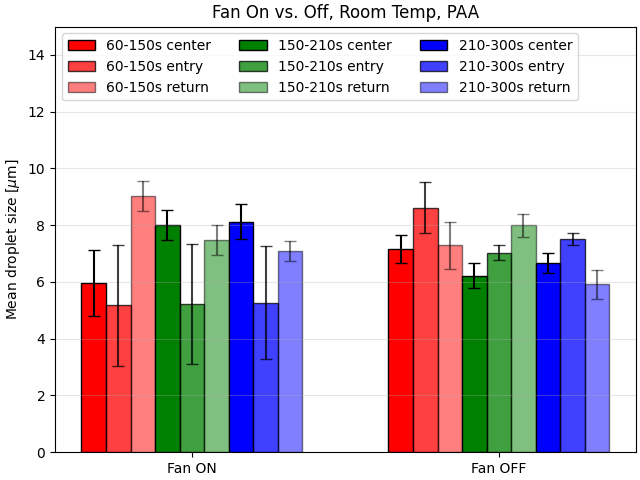

In [100]:
for fL,descriptor in [(glob.glob(path+"*fanOff_roomTemp_acid.txt")+\
                        glob.glob(path+"test1[0-2]_*.txt"),'Fan On vs. Off, Room Temp, PAA')]:
        
    data_means={}
    categories = ['fanOn','fanOff']
    
    for time_range in [(60,150),(150,210),(210,300)]:

        #  Get data in time range for all tests.
        time_avg_data={}
        for filename in natsort.natsorted(fL):
            t, size_bins, size_dist_avg, Cv_avg, Cv_std = process_timeseries(filename,time_offset=60)
            d32,gsd = calc_size_stat(size_bins, size_dist_avg)
            i = np.where((t>=time_range[0]) & (t<=time_range[1]))[0]

            #(np.mean(d32[i]),np.std(d32[i]),np.mean(gsd[i]),np.std(gsd[i])))
            # store mean and error as complex number.
            
            time_avg_data[os.path.basename(filename)] = np.nanmean(d32[i]) + 1j * np.nanmean(gsd[i])

        # Sort data into categories.
        for f in ['center','entry','return']:
            time_range_label = "%i-%is %s" % (*time_range,f)
            data_c=[]
            for c in categories:
                res = [time_avg_data[x] for x in time_avg_data.keys() if (c in x) and (f in x)]
                if len(res)>0: data_c.append( res[0] )
                else: data_c.append(0)
            data_means[time_range_label]=data_c

    
    
    x = np.arange(len(categories))  # the label locations
    width = 0.08  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    plt.grid(alpha=.3, axis='y')
    for attribute, measurement in data_means.items():
        if '60-150s' in attribute: c='r'
        elif '150-210s' in attribute: c='g'
        elif '210-300s' in attribute: c='b'
        else: c=None
            
        if 'entry' in attribute: alpha=.75
        elif 'return' in attribute: alpha=.5
        else: alpha=1
        
        offset = width * multiplier
        rects = ax.bar(x + offset, np.real(measurement), width, label=attribute, fc=c,ec='k',alpha=alpha)
        #ax.bar_label(rects, padding=3)
        errs = ax.errorbar(x + offset, np.real(measurement), yerr=np.imag(measurement), c='k',alpha=alpha,\
                           capsize=4, ls='None', label=None)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(r'Mean droplet size [$\mu$m]')
    ax.set_title(descriptor)
    ax.set_xticks(x + width*4, ['Fan ON','Fan OFF'])
    ax.legend(loc='upper left', ncols=3)
    plt.ylim(0,15)

    plt.savefig('bar_'+descriptor+'.pdf');
        

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_57868/3170094771.py:18: RuntimeWarning: Mean of empty slice
  time_avg_data[os.path.basename(filename)] = np.nanmean(d32[i]) + 1j * np.nanmean(gsd[i])


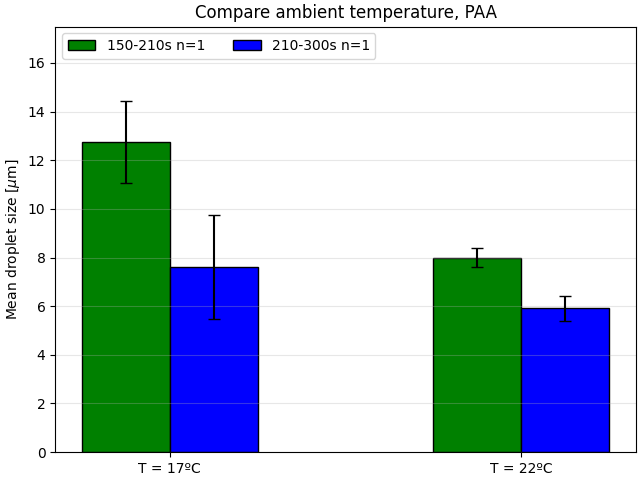

In [120]:
for fL,descriptor in [(glob.glob(path+"test[1-2 4-9]*return*acid.txt"),'Compare ambient temperature, PAA')]:
        
    data_means={}
    categories = ['17C','roomTemp']
    
    for time_range in [(150,210),(210,300)]:

        #  Get data in time range for all tests.
        time_avg_data={}
        for filename in natsort.natsorted(fL):
            t, size_bins, size_dist_avg, Cv_avg, Cv_std = process_timeseries(filename,time_offset=60)
            d32,gsd = calc_size_stat(size_bins, size_dist_avg)
            i = np.where((t>=time_range[0]) & (t<=time_range[1]))[0]

            #(np.mean(d32[i]),np.std(d32[i]),np.mean(gsd[i]),np.std(gsd[i])))
            # store mean and error as complex number.
            
            time_avg_data[os.path.basename(filename)] = np.nanmean(d32[i]) + 1j * np.nanmean(gsd[i])

        # Sort data into categories.
        for n in [1]: #[1,2,3]:
            time_range_label = "%i-%is n=%i" % (*time_range,n)
            data_c=[]
            for c in categories:
                res = [time_avg_data[x] for x in time_avg_data.keys() if ('n%i' % n in x) and (c in x)]
                if len(res)>0: data_c.append( res[0] )
                else: data_c.append(0)
            data_means[time_range_label]=data_c

    
    
    x = np.arange(len(categories))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    plt.grid(alpha=.3, axis='y')
    for attribute, measurement in data_means.items():
        if '60-150s' in attribute: c='r'
        elif '150-210s' in attribute: c='g'
        elif '210-300s' in attribute: c='b'
        else: c=None
            
        if 'n=2' in attribute: alpha=0.75
        elif 'n=3' in attribute: alpha=0.5
        else: alpha=1
        
        offset = width * multiplier
        rects = ax.bar(x + offset, np.real(measurement), width, label=attribute, fc=c,ec='k',alpha=alpha)
        #ax.bar_label(rects, padding=3)
        errs = ax.errorbar(x + offset, np.real(measurement), yerr=np.imag(measurement), c='k',alpha=alpha,\
                           capsize=4, ls='None', label=None)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(r'Mean droplet size [$\mu$m]')
    ax.set_title(descriptor)
    ax.set_xticks(x + width/2, ['T = 17ºC','T = 22ºC'])
    ax.legend(loc='upper left', ncols=2)
    plt.ylim(0,17.5)

    plt.savefig('bar_'+descriptor+'.pdf');
        

## Size distribution line plots

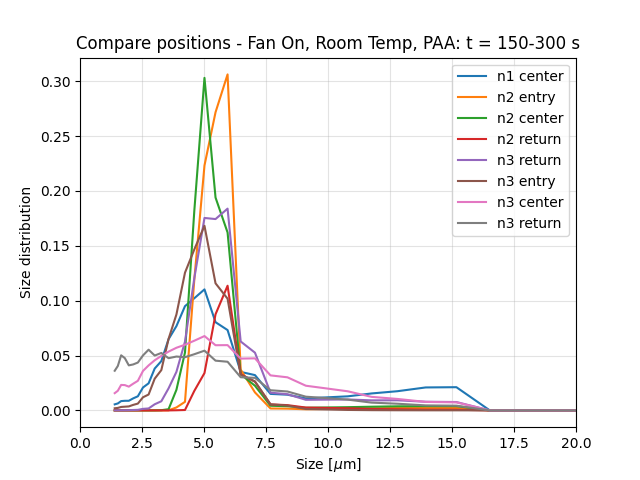

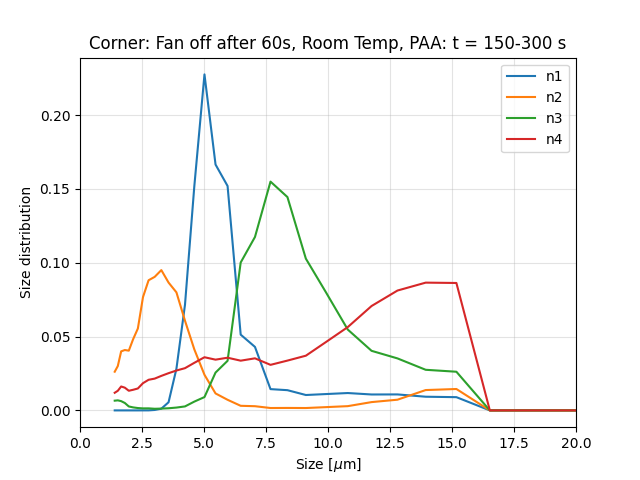

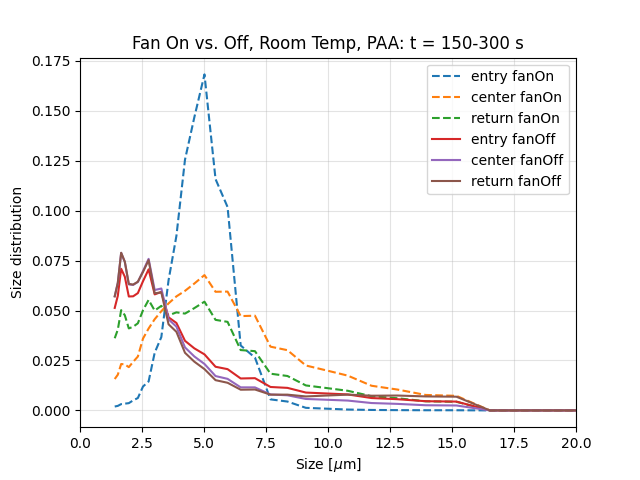

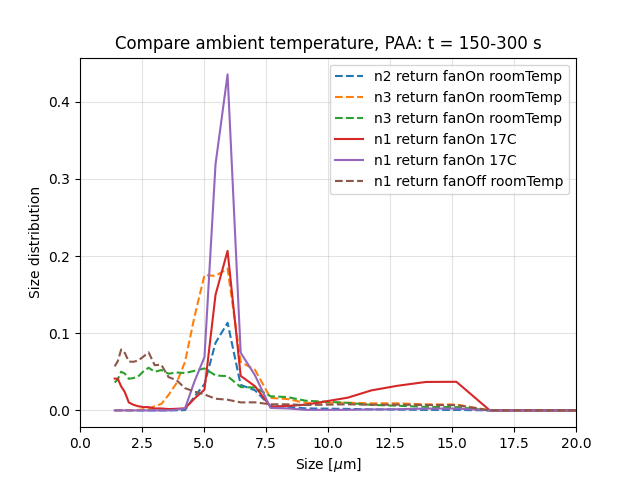

In [219]:
for time_range in [(150,300)]: #[(60,150),(150,210),(210,300)]:

    for fL,descriptor in [(glob.glob(path+"test[26789]_*fanOn_roomTemp_acid.txt")+\
                           glob.glob(path+"test1?_*fanOn_roomTemp_acid.txt"), 'Compare positions - Fan On, Room Temp, PAA'),\
                          (glob.glob(path+"*fan60s_roomTemp_acid.txt"),'Corner: Fan off after 60s, Room Temp, PAA'),\
                           (glob.glob(path+"*fanOff_roomTemp_acid.txt")+\
                            glob.glob(path+"test1[0-2]_*.txt"),'Fan On vs. Off, Room Temp, PAA'),\
                           (glob.glob(path+"test[1-2 4-9]*return*acid.txt"),'Compare ambient temperature, PAA')]:
        
        
        
        fig=plt.figure()
        plt.grid(alpha=.35)
        plt.xlabel(r'Size [$\mu$m]')
        plt.ylabel('Size distribution')
        plt.title('%s: t = %i-%i s' % (descriptor,*time_range))
        
        for filename in natsort.natsorted(fL):
            
            t, size_bins, size_dist_avg, Cv_avg, Cv_std = process_timeseries(filename,time_offset=60)
            #d32,gsd = calc_size_stat(size_bins, size_dist_avg)
        
            case = os.path.splitext(os.path.basename(filename))[0]
            
            i = np.where((t>=time_range[0]) & (t<=time_range[1]))[0]

            # Custom line styles and labels.
            ls='-'; c=None; short_case=case
            
            if ('Fan On vs. Off' in descriptor) & ('fanOn' in case): ls='--'
            if ('ambient temperature' in descriptor) & ( 'roomTemp' in case): ls='--'

            if 'Compare positions' in descriptor: short_case = ' '.join(case.split('_')[1:3])                
            if 'Corner: Fan off after' in descriptor: short_case = case.split('_')[1]
            if 'Fan On vs. Off' in descriptor: short_case = ' '.join(case.split('_')[2:4])
            if 'Compare ambient' in descriptor: short_case = ' '.join(case.split('_')[1:5])
            
            plt.plot(size_bins, np.nanmean(size_dist_avg[i,:],axis=0), label=short_case, ls=ls, c=c)

        
        plt.legend()
        plt.xlim(0,20)
        plt.savefig('%s.pdf' % descriptor)
        